## Using DNAMite for Survival Analysis Feature Selection

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from dnamite.models import DNAMiteSurvival

Using the metabric dataset as an example.

In [3]:
X = pd.read_csv(
    "https://raw.githubusercontent.com/chl8856/DeepHit/master/sample%20data/METABRIC/cleaned_features_final.csv"
)

y = pd.read_csv(
    "https://raw.githubusercontent.com/chl8856/DeepHit/master/sample%20data/METABRIC/label.csv"
)

y = np.array(list(zip(y["label"], y["event_time"])), dtype=[('event', 'bool'), ('time', 'float32')])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
        

If you just want to select features, then set `fit_pairs = False` which will not fit any interactions.

Notes on parameters:
- `reg_param`: controls the strength of the regularization. Use larger values to select fewer features.
- `gamma`: essentially controls how much a feature needs to be regularized before it is eliminated from the model. Smaller values means features will be pruned earlier in the training, while larger values means features take longer to be eliminated. 
- `device`: I'm using a GPU in this example, which is recommended in general but for smaller datasets you will also be fine with CPU training.

Both of these parameters require a little bit of manual tuning to get correct depending on the dataset. I try to optimize them by first setting `gamma` such that the number of features stabilizes before the end of training and then changing `reg_param` to increase/decrease the number of features. Normally around `gamma = 0.5` works well but for this dataset a much smaller value is needed because the dataset is very small. If you don't have a preset feature budget in mind then you can of course compare different choices on a validation set.

In [4]:
model = DNAMiteSurvival(
    n_features=X_train.shape[1],
    n_eval_times=100,
    device=device,
    reg_param=0.05,
    gamma=0.04,
    batch_size=64,
    fit_pairs=False
)
model.select_features(X_train, y_train)

Discretizing features...


100%|██████████| 79/79 [00:00<00:00, 15209.31it/s]


Epoch 1 | Train loss: 24.797 | Test loss: 22.644 | Active features: 79


Epoch 2 | Train loss: 21.251 | Test loss: 20.251 | Active features: 79


Epoch 3 | Train loss: 19.854 | Test loss: 19.232 | Active features: 79


Epoch 4 | Train loss: 18.595 | Test loss: 18.392 | Active features: 74


Epoch 5 | Train loss: 17.749 | Test loss: 17.856 | Active features: 54


Epoch 6 | Train loss: 17.289 | Test loss: 17.466 | Active features: 38


Epoch 7 | Train loss: 16.852 | Test loss: 17.092 | Active features: 20


Epoch 8 | Train loss: 16.472 | Test loss: 16.609 | Active features: 18


Epoch 9 | Train loss: 16.256 | Test loss: 16.509 | Active features: 16


Epoch 10 | Train loss: 15.903 | Test loss: 16.007 | Active features: 16


Epoch 11 | Train loss: 15.830 | Test loss: 15.974 | Active features: 16


Epoch 12 | Train loss: 15.740 | Test loss: 15.870 | Active features: 16


Epoch 13 | Train loss: 15.594 | Test loss: 15.932 | Active features: 15


Epoch 14 | Train loss: 15.601 | Test loss: 15.903 | Active features: 14


Epoch 15 | Train loss: 15.377 | Test loss: 15.818 | Active features: 14


Epoch 16 | Train loss: 15.328 | Test loss: 15.772 | Active features: 14


Epoch 17 | Train loss: 15.309 | Test loss: 15.860 | Active features: 14


Epoch 18 | Train loss: 15.238 | Test loss: 15.760 | Active features: 13


Epoch 19 | Train loss: 15.185 | Test loss: 15.973 | Active features: 13


Epoch 20 | Train loss: 15.165 | Test loss: 15.978 | Active features: 13


Epoch 21 | Train loss: 15.147 | Test loss: 15.981 | Active features: 13


Epoch 22 | Train loss: 15.098 | Test loss: 15.907 | Active features: 13


/home/mvanness/.venvs/dnamite/lib/python3.10/site-packages/dnamite/models/dnamite.py:862: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(os.pa

Epoch 23 | Train loss: 15.075 | Test loss: 15.908 | Active features: 13
Early stopping at 23 epochs: Test loss has not improved for 5 consecutive epochs.
Number of main features selected:  13


In [5]:
# Obtain the features selected
model.selected_feats

['age_at_diagnosis',
 'size',
 'lymph_nodes_positive',
 'NPI',
 'ER_Expr',
 'PR_Expz',
 'Her2_Expr',
 'Treatment.7',
 'group',
 'group.3',
 'Pam50_Subtype.2',
 'site.1',
 'site.2']

If you are also interested in learning some interactions then set `fit_pairs = True` and also set `pair_reg_param` to control the number of interactions selected. You may also need to set `pair_gamma` if a different value of gamma is needed for interaction select, although the default is to use the same `gamma` for both mains and pairs.

This also doesn't work very well on metabric because the interactions on metabric don't have much signal.

In [6]:
model = DNAMiteSurvival(
    n_features=X_train.shape[1],
    n_eval_times=100,
    device=device,
    reg_param=0.05,
    pair_reg_param=0.002,
    gamma=0.04,
    pair_gamma=0.01,
    batch_size=64,
    fit_pairs=True
)
model.select_features(X_train, y_train)

Discretizing features...


100%|██████████| 79/79 [00:00<00:00, 33859.60it/s]


Epoch 1 | Train loss: 24.794 | Test loss: 22.901 | Active features: 79


Epoch 2 | Train loss: 21.159 | Test loss: 20.685 | Active features: 79


Epoch 3 | Train loss: 19.793 | Test loss: 19.666 | Active features: 79


Epoch 4 | Train loss: 18.482 | Test loss: 18.729 | Active features: 74


Epoch 5 | Train loss: 17.317 | Test loss: 18.382 | Active features: 50


Epoch 6 | Train loss: 16.781 | Test loss: 18.152 | Active features: 29


Epoch 7 | Train loss: 16.445 | Test loss: 18.019 | Active features: 21


Epoch 8 | Train loss: 16.184 | Test loss: 17.938 | Active features: 18


Epoch 9 | Train loss: 15.983 | Test loss: 17.914 | Active features: 15


Epoch 10 | Train loss: 15.866 | Test loss: 17.836 | Active features: 15


Epoch 11 | Train loss: 15.678 | Test loss: 17.614 | Active features: 14


Epoch 12 | Train loss: 15.515 | Test loss: 17.494 | Active features: 14


Epoch 13 | Train loss: 15.466 | Test loss: 17.524 | Active features: 13


Epoch 14 | Train loss: 15.290 | Test loss: 17.525 | Active features: 13


Epoch 15 | Train loss: 15.233 | Test loss: 17.457 | Active features: 13


Epoch 16 | Train loss: 15.254 | Test loss: 17.424 | Active features: 13


Epoch 17 | Train loss: 15.126 | Test loss: 17.536 | Active features: 13


Epoch 18 | Train loss: 15.087 | Test loss: 17.477 | Active features: 13


Epoch 19 | Train loss: 15.015 | Test loss: 17.426 | Active features: 13


Epoch 20 | Train loss: 14.954 | Test loss: 17.487 | Active features: 13


/home/mvanness/.venvs/dnamite/lib/python3.10/site-packages/dnamite/models/dnamite.py:862: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(os.pa

Epoch 21 | Train loss: 14.970 | Test loss: 17.495 | Active features: 13
Early stopping at 21 epochs: Test loss has not improved for 5 consecutive epochs.
Number of main features selected:  13


Epoch 1 | Train loss: 14.740 | Test loss: 17.156 | Active pairs: 78


Epoch 2 | Train loss: 14.776 | Test loss: 17.134 | Active pairs: 78


Epoch 3 | Train loss: 14.748 | Test loss: 17.121 | Active pairs: 77


Epoch 4 | Train loss: 14.746 | Test loss: 17.105 | Active pairs: 40


Epoch 5 | Train loss: 14.700 | Test loss: 17.091 | Active pairs: 13


Epoch 6 | Train loss: 14.680 | Test loss: 17.090 | Active pairs: 6


Epoch 7 | Train loss: 14.693 | Test loss: 17.089 | Active pairs: 3


Epoch 8 | Train loss: 14.685 | Test loss: 17.089 | Active pairs: 3


Epoch 9 | Train loss: 14.697 | Test loss: 17.088 | Active pairs: 3


Epoch 10 | Train loss: 14.673 | Test loss: 17.087 | Active pairs: 3


Epoch 11 | Train loss: 14.667 | Test loss: 17.085 | Active pairs: 3


Epoch 12 | Train loss: 14.694 | Test loss: 17.083 | Active pairs: 3


Epoch 13 | Train loss: 14.679 | Test loss: 17.079 | Active pairs: 3


Epoch 14 | Train loss: 14.680 | Test loss: 17.072 | Active pairs: 3


Epoch 15 | Train loss: 14.664 | Test loss: 17.072 | Active pairs: 3


Epoch 16 | Train loss: 14.673 | Test loss: 17.064 | Active pairs: 3


Epoch 17 | Train loss: 14.682 | Test loss: 17.050 | Active pairs: 3


Epoch 18 | Train loss: 14.634 | Test loss: 17.055 | Active pairs: 3


Epoch 19 | Train loss: 14.628 | Test loss: 17.048 | Active pairs: 3


Epoch 20 | Train loss: 14.583 | Test loss: 17.052 | Active pairs: 3


Epoch 21 | Train loss: 14.607 | Test loss: 17.045 | Active pairs: 3


Epoch 22 | Train loss: 14.597 | Test loss: 17.057 | Active pairs: 3


Epoch 23 | Train loss: 14.587 | Test loss: 17.060 | Active pairs: 3


Epoch 24 | Train loss: 14.593 | Test loss: 17.063 | Active pairs: 3


Epoch 25 | Train loss: 14.540 | Test loss: 17.075 | Active pairs: 3


Epoch 26 | Train loss: 14.539 | Test loss: 17.076 | Active pairs: 3
Early stopping at 26 epochs: Test loss has not improved for 5 consecutive epochs.
Number of interaction features selected:  3


/home/mvanness/.venvs/dnamite/lib/python3.10/site-packages/dnamite/models/dnamite.py:862: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(os.pa

In [7]:
print(model.selected_feats)
print(model.selected_pairs)

['age_at_diagnosis', 'size', 'lymph_nodes_positive', 'stage', 'NPI', 'grade.2', 'ER_IHC_status', 'ER_Expr.1', 'PR_Expz', 'group', 'group.3', 'site.1', 'site.2']
[['size', 'lymph_nodes_positive'], ['lymph_nodes_positive', 'NPI'], ['stage', 'PR_Expz']]


If you only want to do feature selection and then use these features for another model then you can stop here.

Of course you can also use DNAMite for actual prediction if you'd like. If so, you can just call `model.fit(...)`. The model with automatically fit to the features selected from the previous step.

In [8]:
model.fit(X_train, y_train)

SPlIT 0
Found selected features. Using only those features.
TRAINING MAINS


/home/mvanness/.venvs/dnamite/lib/python3.10/site-packages/dnamite/models/dnamite.py:862: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(os.pa

Early stopping at 22 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


/home/mvanness/.venvs/dnamite/lib/python3.10/site-packages/dnamite/models/dnamite.py:862: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(os.pa

Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 1
Found selected features. Using only those features.
TRAINING MAINS


/home/mvanness/.venvs/dnamite/lib/python3.10/site-packages/dnamite/models/dnamite.py:862: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(os.pa

Early stopping at 28 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


/home/mvanness/.venvs/dnamite/lib/python3.10/site-packages/dnamite/models/dnamite.py:862: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(os.pa

Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 2
Found selected features. Using only those features.
TRAINING MAINS


/home/mvanness/.venvs/dnamite/lib/python3.10/site-packages/dnamite/models/dnamite.py:862: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(os.pa

Early stopping at 31 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


/home/mvanness/.venvs/dnamite/lib/python3.10/site-packages/dnamite/models/dnamite.py:862: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(os.pa

Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 3
Found selected features. Using only those features.
TRAINING MAINS


/home/mvanness/.venvs/dnamite/lib/python3.10/site-packages/dnamite/models/dnamite.py:862: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(os.pa

Early stopping at 33 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


/home/mvanness/.venvs/dnamite/lib/python3.10/site-packages/dnamite/models/dnamite.py:862: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(os.pa

Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 4
Found selected features. Using only those features.
TRAINING MAINS


/home/mvanness/.venvs/dnamite/lib/python3.10/site-packages/dnamite/models/dnamite.py:862: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(os.pa

Early stopping at 36 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


/home/mvanness/.venvs/dnamite/lib/python3.10/site-packages/dnamite/models/dnamite.py:862: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(os.pa

Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.


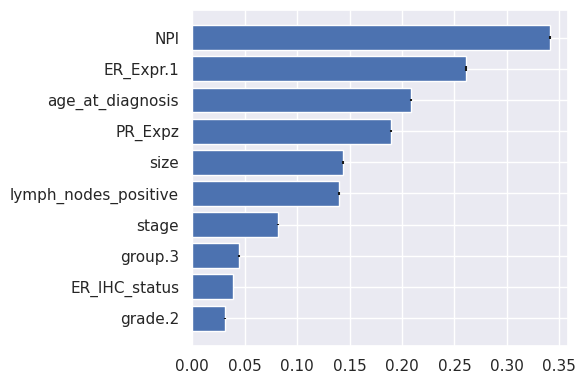

In [9]:
model.plot_feature_importances(k=10, eval_time=365*2)

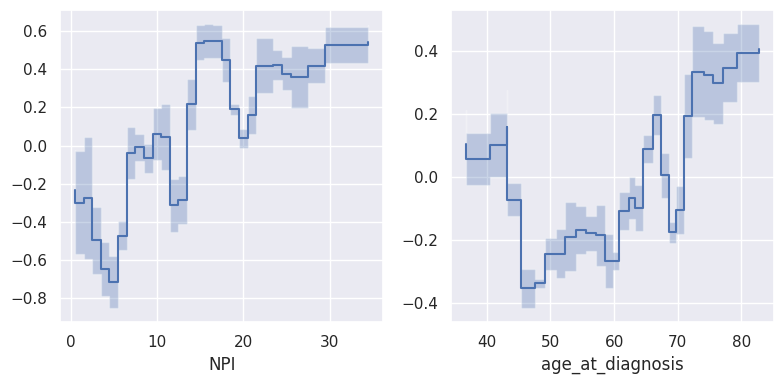

In [10]:
model.plot_shape_function(["NPI", "age_at_diagnosis"], eval_time=365*2)